### Walgreen Stock Price Prediction

In [94]:
## import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


**1. Loading the data from walgreen_data.csv file**

In [95]:
df = pd.read_csv('Walgreen_Stock.csv')

In [96]:
df.shape

(10468, 7)

In [106]:
df.tail(251)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-17,40.130001,40.177502,39.459999,39.465000,37.506897,111762400
2017-08-18,39.465000,39.875000,39.180000,39.375000,37.421360,109712400
2017-08-21,39.375000,39.472500,38.777500,39.302502,37.352448,105474000
2017-08-22,39.557499,40.000000,39.505001,39.945000,37.963074,86418400
2017-08-23,39.767502,40.117500,39.720001,39.994999,38.010601,77596400
...,...,...,...,...,...,...
2018-08-09,52.382500,52.445000,51.799999,52.220001,50.203369,93970400
2018-08-10,51.840000,52.275002,51.667500,51.882500,50.053829,98444800
2018-08-13,52.327499,52.737499,51.924999,52.217499,50.377022,103563600


**2. Data Preprocessing**

In [98]:
## Finding Null values
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [99]:
## Converting the date column into datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10468 non-null  datetime64[ns]
 1   Open       10468 non-null  float64       
 2   High       10468 non-null  float64       
 3   Low        10468 non-null  float64       
 4   Close      10468 non-null  float64       
 5   Adj Close  10468 non-null  float64       
 6   Volume     10468 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 572.6 KB


In [101]:
## making date column as index
df.set_index('Date', inplace=True)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10468 entries, 1980-12-12 to 2022-06-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10468 non-null  float64
 1   High       10468 non-null  float64
 2   Low        10468 non-null  float64
 3   Close      10468 non-null  float64
 4   Adj Close  10468 non-null  float64
 5   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 572.5 KB


In [107]:
df.drop(df[df.index < pd.to_datetime('2017-08-17')].index, inplace=True)

In [108]:
df.shape

(251, 6)

In [109]:
## converting sequential data by sorting based on date
df = df.sort_index()

In [110]:
## Data Normalization 
scaler = MinMaxScaler()
scaler_values = scaler.fit_transform(df[df.columns])

In [111]:
scaler_values

array([[0.17500415, 0.15020312, 0.14669584, 0.12246601, 0.11627416,
        0.20824407],
       [0.13079601, 0.12973614, 0.12776739, 0.11643485, 0.11054779,
        0.20132587],
       [0.12481296, 0.10250339, 0.10055765, 0.11157655, 0.1059344 ,
        0.18702239],
       ...,
       [0.98587323, 1.        , 0.98935264, 0.97704795, 0.97787906,
        0.1805753 ],
       [1.        , 0.99340325, 0.9988169 , 0.99179085, 0.99208757,
        0.11115161],
       [0.98437753, 0.99644804, 1.        , 1.        , 1.        ,
        0.21994765]], shape=(251, 6))

In [112]:
## the above normalized values are in numpy array format, converting them into dataframe
df_scaled = pd.DataFrame(scaler_values, columns=df.columns, index=df.index)
df_scaled.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-17,0.175004,0.150203,0.146696,0.122466,0.116274,0.208244
2017-08-18,0.130796,0.129736,0.127767,0.116435,0.110548,0.201326
2017-08-21,0.124813,0.102503,0.100558,0.111577,0.105934,0.187022
2017-08-22,0.136945,0.138194,0.149738,0.154632,0.146813,0.122715
2017-08-23,0.150906,0.146143,0.164272,0.157983,0.149995,0.092943


**3. Plotting the Columns**

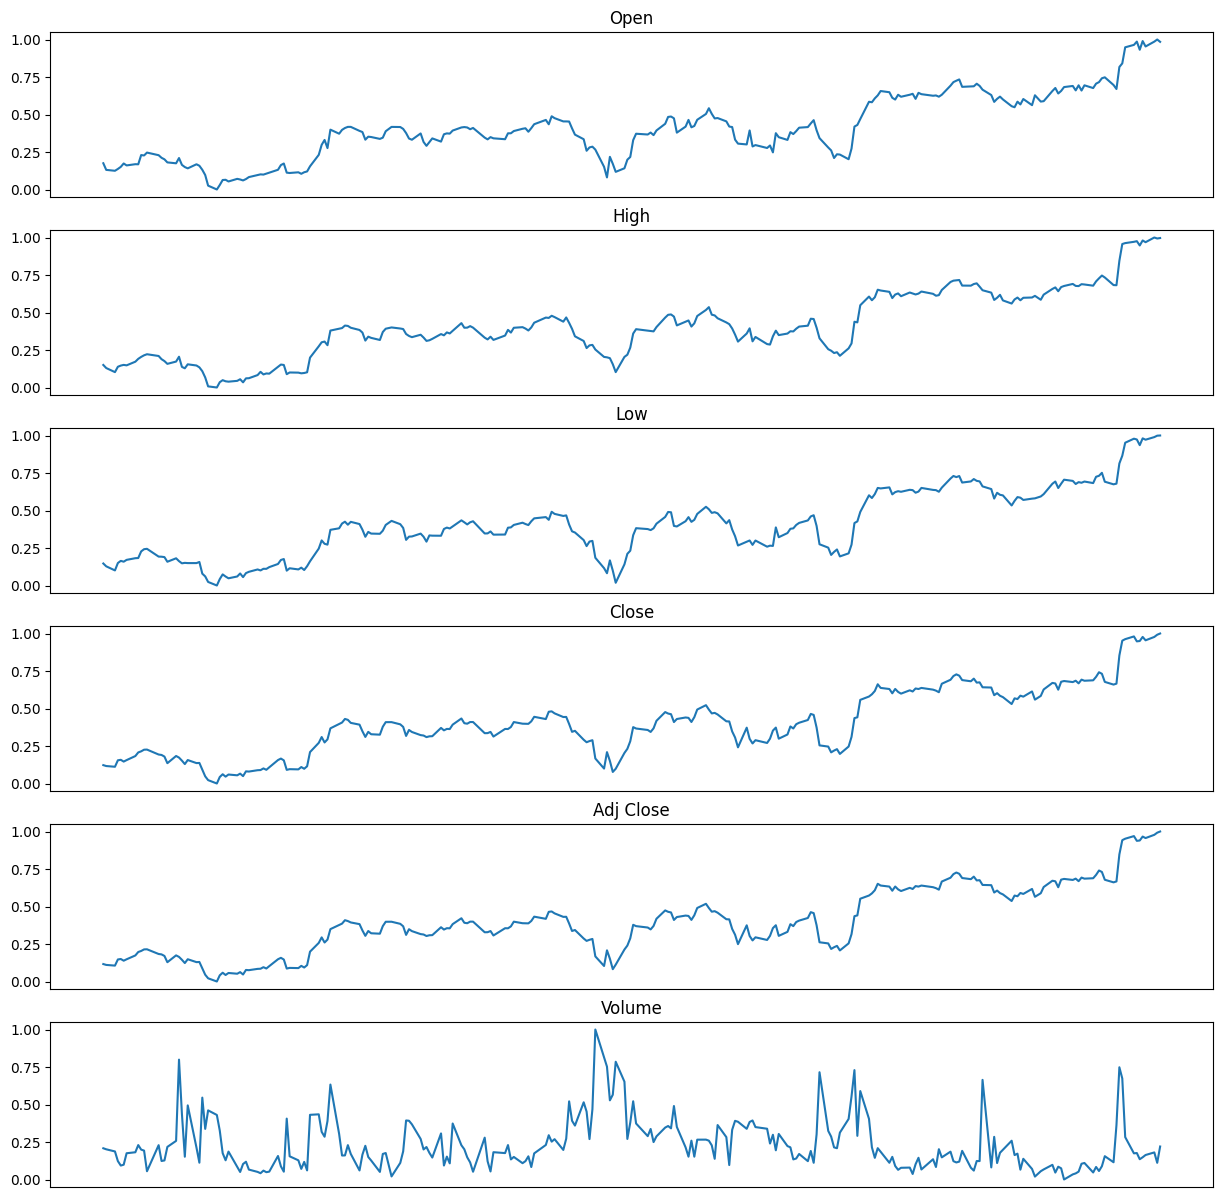

In [113]:
plt.rcParams['figure.figsize'] = (15,15)
figure, axes = plt.subplots(6)

for ax, col in zip(axes, df_scaled.columns):
    ax.plot(df_scaled[col])
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)

**4. Creating the sliding window sequences**

In [85]:
## [1,2,3,4.... 10]
# window_size = 3
# [1,2,3] => [4]
# [2,3,4] => [5]
# [3,4,5] => [6]

In [114]:
def create_sequence(data,window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)

In [115]:
X, y = create_sequence(df_scaled, window_size=60)

In [116]:
X.shape, y.shape

((191, 60, 6), (191, 6))

**5. Train - Test Split**

In [117]:
X_train,X_text,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_text.shape, y_train.shape, y_test.shape

((152, 60, 6), (39, 60, 6), (152, 6), (39, 6))

**6. Building LSTM model**

In [118]:
model = keras.Sequential([
# Adding the first LSTM layer and some Dropout regularisation
keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
keras.layers.Dropout(0.3),

# Adding the Second LSTM layer and some Dropout regularisation
keras.layers.LSTM(units=50, return_sequences=True),
keras.layers.Dropout(0.3),

# Adding the Third LSTM layer and some Dropout regularisation
keras.layers.LSTM(units=50, return_sequences=False),
keras.layers.Dropout(0.3),

# Adding the output layer
keras.layers.Dense(units=y_train.shape[1]),

])


e:\data_science_projects\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [121]:
# compilation 
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['RootMeanSquaredError'])

In [122]:
#early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=10,
                                restore_best_weights=True)

In [123]:
lstm_model = model.fit(X_train, y_train,
                        validation_split = 0.2,
                        epochs = 100,
                        batch_size = 3,
                        callbacks=[early_stopping])

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 458ms/step - RootMeanSquaredError: 0.2511 - loss: 0.0630 - val_RootMeanSquaredError: 0.1731 - val_loss: 0.0300
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - RootMeanSquaredError: 0.1778 - loss: 0.0316 - val_RootMeanSquaredError: 0.1667 - val_loss: 0.0278
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - RootMeanSquaredError: 0.1739 - loss: 0.0302 - val_RootMeanSquaredError: 0.1722 - val_loss: 0.0297
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - RootMeanSquaredError: 0.1579 - loss: 0.0249 - val_RootMeanSquaredError: 0.1687 - val_loss: 0.0284
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - RootMeanSquaredError: 0.1536 - loss: 0.0236 - val_RootMeanSquaredError: 0.1469 - val_loss: 0.0216
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - RootMeanSquaredError: 0.1547 - loss: 0.0239 - val_RootMeanSquaredError: 0.1409 - val_loss: 0.0199
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - RootMeanSquaredError: 0

In [124]:
lstm_model.history

{'RootMeanSquaredError': [0.25105613470077515,
  0.1777944713830948,
  0.1738879233598709,
  0.15791799128055573,
  0.15361803770065308,
  0.15470732748508453,
  0.14105583727359772,
  0.15921857953071594,
  0.15131567418575287,
  0.14350266754627228,
  0.14943666756153107,
  0.1265614628791809,
  0.13240359723567963,
  0.13073493540287018,
  0.11818713694810867,
  0.12209610641002655,
  0.11408618837594986,
  0.11577145010232925,
  0.11110974848270416,
  0.11380743235349655,
  0.12195334583520889,
  0.11204681545495987,
  0.1039976179599762,
  0.11130952090024948,
  0.10477905720472336,
  0.10412043333053589,
  0.11667793244123459,
  0.09780105203390121,
  0.09784124791622162,
  0.09606148302555084,
  0.09910973906517029,
  0.09714477509260178,
  0.09798145294189453,
  0.09419851005077362,
  0.09485314786434174,
  0.09347338229417801,
  0.08729706704616547,
  0.0905013456940651,
  0.0903313010931015,
  0.09278301894664764,
  0.08957840502262115,
  0.08720377087593079,
  0.090439401566

In [143]:
predictions = model.predict(X_text)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


**7. Forecasting the Data**

In [144]:
predictions[:5]

array([[0.6128814 , 0.6134118 , 0.5965744 , 0.6056531 , 0.6051468 ,
        0.2256509 ],
       [0.456287  , 0.4587983 , 0.44727618, 0.4476307 , 0.44570276,
        0.2605672 ],
       [0.5971745 , 0.6001592 , 0.5834724 , 0.59016645, 0.587904  ,
        0.21500793],
       [0.44187975, 0.46416748, 0.44087228, 0.45360032, 0.46419066,
        0.38627058],
       [0.12187265, 0.1375786 , 0.07017519, 0.12159754, 0.14106834,
        0.58173513]], dtype=float32)

In [145]:
# inverse forecasting
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

In [147]:
y_test_rescaled[:5]

array([[4.6812500e+01, 4.7087502e+01, 4.6235001e+01, 4.6365002e+01,
        4.4574474e+01, 1.0284760e+08],
       [4.3200001e+01, 4.4075001e+01, 4.3112499e+01, 4.4052502e+01,
        4.2188595e+01, 1.5381600e+08],
       [4.6572498e+01, 4.6797501e+01, 4.5727501e+01, 4.6277500e+01,
        4.4490345e+01, 9.0950800e+07],
       [4.3090000e+01, 4.3705002e+01, 4.2942501e+01, 4.3107498e+01,
        4.1283573e+01, 1.6070440e+08],
       [4.0072498e+01, 4.0250000e+01, 3.8757500e+01, 3.8787498e+01,
        3.6995518e+01, 2.1756200e+08]])

In [146]:
predictions[:5]

array([[4.67167664e+01, 4.70237274e+01, 4.61148262e+01, 4.66753616e+01,
        4.48093758e+01, 1.16920384e+08],
       [4.43611984e+01, 4.47385368e+01, 4.39063339e+01, 4.43172722e+01,
        4.24277000e+01, 1.27266768e+08],
       [4.64804993e+01, 4.68278542e+01, 4.59210129e+01, 4.64442596e+01,
        4.45518112e+01, 1.13766664e+08],
       [4.41444740e+01, 4.48178940e+01, 4.38116035e+01, 4.44063530e+01,
        4.27038612e+01, 1.64515152e+08],
       [3.93307686e+01, 3.99909134e+01, 3.83280678e+01, 3.94520416e+01,
        3.78772583e+01, 2.22435136e+08]], dtype=float32)

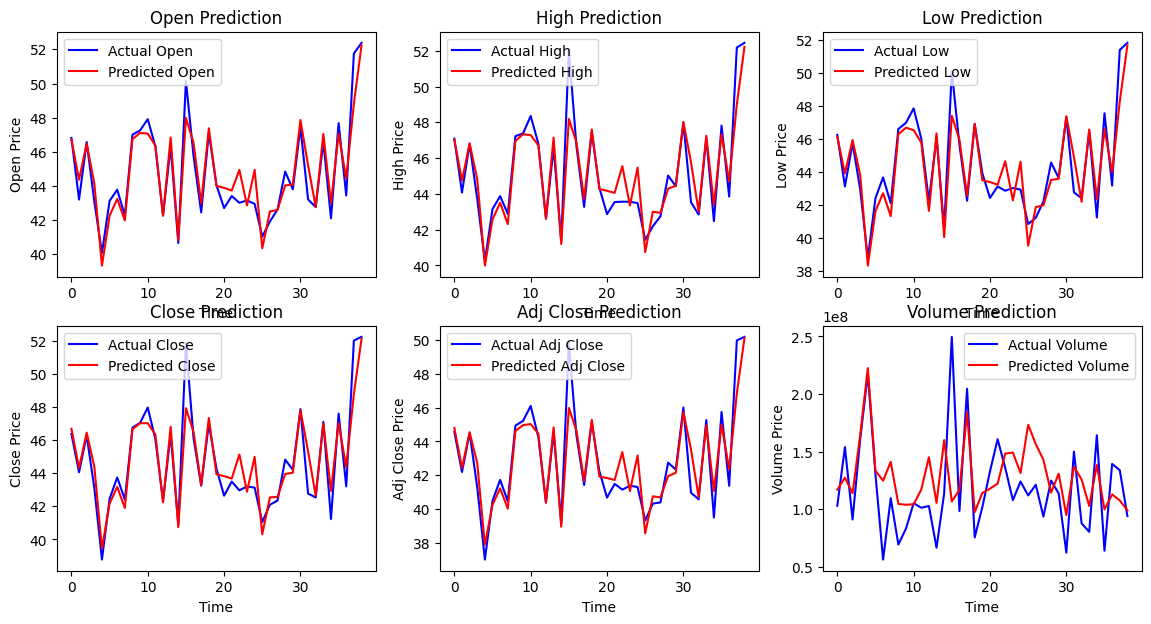

In [ ]:
# plotting the results
plt.figure(figsize=(14,7))

for i, col in enumerate(df_scaled.columns):
    plt.subplot(2,3,i+1)
    plt.plot(y_test_rescaled[:,i], color = 'blue', label=f'Actual {col}')
    plt.plot(predictions[:,i], color = 'red', label=f'Predicted {col}')
    plt.title(f'{col} Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()